# PCA

generate PCA figure based on variant calling (zarr) file

In [1]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import functools
from collections import OrderedDict
import timeit

import numpy as np; print('numpy', np.__version__)
import matplotlib as mpl; print('matplotlib', mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd; print('pandas',pd.__version__)
import allel; print('allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

sys.path.append('/home/seoks/Documents/ngs_scripts-master/ngs_py_utils/')
import allel_helpers; print('allel_helpers', allel_helpers.__version__)

from IPython.display import display, HTML

3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
numpy 1.25.1
matplotlib 3.9.2
pandas 2.2.2
allel 1.3.6
zarr 2.15.0
allel_helpers 0.2.1


In [2]:
%matplotlib inline

In [3]:
start_tic = timeit.default_timer()

In [4]:
INFN_ZARR = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/AalbF5_June2024_DP8_mm0.1.vcf.gz.zarr/'

REFERENCE_FAI = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/AalbF5.fa.fai'

# META_FN = 'Pacific albopictus ss.xlsx'
META_FN = 'Albo_Pacific.xlsx'
GROUP_COL = 'Collection_Location'

ADD_REFERENCE = False

CHROMS = ['NC_085136.1','NC_085137.1','NC_085138.1']

FILTER_SNP = True
FILTER_BIALLELIC = True
FILTER_SINGLETON = True # also filters biallelic
MAX_MISSING = 0.1
MIN_FMTDP = 8

In [5]:
INFN_ZARR

'/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/AalbF5_June2024_DP8_mm0.1.vcf.gz.zarr/'

# Load callset from zarr archive

In [6]:
callset = zarr.open_group(INFN_ZARR, mode='r')

In [7]:
# reading the chromosome names and sizes from the reference fasta index (fai)
fai = pd.read_table(REFERENCE_FAI,
            names=['chrom','len','offset','lbases','lwidth'])
fai.sort_values('len', ascending=False, inplace=True)
fai

,chrom,len,offset,lbases,lwidth
1,NC_085137.1,518725454,342405067,80,81
2,NC_085138.1,450188506,867614686,80,81
0,NC_085136.1,338177654,96,80,81
941,NW_026917309.1,225000,1346000343,80,81
1052,NW_026917420.1,220370,1349794324,80,81
...,...,...,...,...,...
457,NW_026916825.1,1000,1328317283,80,81
455,NW_026916823.1,1000,1328257192,80,81
446,NW_026916814.1,1000,1328246905,80,81
426,NW_026916794.1,987,1327925312,80,81


In [8]:
# @TCC TEMP : just use first few chroms
# CHROMS = fai['chrom'].values[0:5]

# all chroms (from callset)fig = fig_pca2(coords, model, "PCA of Aedes albopictus Pacific Samples", 
CHROMS = list(callset.keys())

In [9]:
# Creating a metadata file for the sample list


if False:
    tmp = pd.DataFrame(columns=['site','group'], 
                       index=list(callset[list(callset.keys())[0]]['samples']))
    tmp.rename_axis('sample', inplace=True)
    tmp['site'] = ''
    tmp['group'] = '0'
    tmp.to_csv('meta.tsv', sep='\t')

## Load metadata file
sets:
sample_ids, sample_idxs, meta

In [10]:
meta = pd.read_excel(META_FN,
                     skiprows=0)
meta.set_index('banked_sample_id', inplace=True)
meta_all_samples = meta.index.values

# reorder to match order in callset (callset_all_sample_ids)
callset_samples = list(callset[list(callset.keys())[0]]['samples'])
meta = meta.reindex([x for x in callset_samples if x in meta.index.values])
sample_ids = meta.index.values
sample_idxs = [callset_samples.index(x) for x in sample_ids]
meta['idx'] = pd.Series(sample_idxs, index=meta.index)

In [11]:
meta

,Collection_Location,Regions,District,ID,idx
banked_sample_id,,,,,
Ae17ORA045,California,California,California,Ae17ORA045,0
Ae17GLA019,California,California,California,Ae17GLA019,1
Ab22HMR4-002,Oahu,Oahu,Oahu,Ab22HMR4-002,2
Ab22HMR4-001,Oahu,Oahu,Oahu,Ab22HMR4-001,3
Ab21GELI003,RMI,RMI,RMI,Ab21GELI003,4
...,...,...,...,...,...
Ab23HNL003,Oahu,Oahu,Oahu,Ab23HNL003,130
Ab23HNL004,Oahu,Oahu,Oahu,Ab23HNL004,131
AbKAHO113,Big Island,Big Island,Big Island,AbKAHO113,132


In [12]:
meta.shape

(133, 5)

In [13]:
# makeing the group column
meta['group'] = meta['Collection_Location'].fillna('Unknown')
# meta['group'] = meta[['Collection\nLocation','Year']].agg(lambda x:f'{x[0]}-{x[1]}', axis=1)
meta

,Collection_Location,Regions,District,ID,idx,group
banked_sample_id,,,,,,
Ae17ORA045,California,California,California,Ae17ORA045,0,California
Ae17GLA019,California,California,California,Ae17GLA019,1,California
Ab22HMR4-002,Oahu,Oahu,Oahu,Ab22HMR4-002,2,Oahu
Ab22HMR4-001,Oahu,Oahu,Oahu,Ab22HMR4-001,3,Oahu
Ab21GELI003,RMI,RMI,RMI,Ab21GELI003,4,RMI
...,...,...,...,...,...,...
Ab23HNL003,Oahu,Oahu,Oahu,Ab23HNL003,130,Oahu
Ab23HNL004,Oahu,Oahu,Oahu,Ab23HNL004,131,Oahu
AbKAHO113,Big Island,Big Island,Big Island,AbKAHO113,132,Big Island


In [14]:
# # load metadata
# """reads a tsv/csv file into a pandas dataframe
# reorders to match order in callset_all_sample_ids
# adds 'idx' column
# """
# callset_samples = list(callset[list(callset.keys())[0]]['samples'])
# sep = '\t'
# header_lines = 0
# sample_column_idx = 0
# sample_ids_to_drop = 0

# meta = pd.read_csv(META_FN, sep=sep, header=header_lines,
#                    index_col=sample_column_idx, comment='#')
# # Removing samples if requested
# if sample_ids_to_drop:
#     for s in sample_ids_to_drop: # Drop one at a time so we can tolerate already missing samples
#         try:
#             meta.drop((s), inplace=True)
#         except ValueError as e:
#             print('WARNING:', e, file=sys.stderr)
# # reorder to match order in callset (callset_all_sample_ids)
# meta = meta.reindex([x for x in callset_samples if x in meta.index.values])
# # display(meta)
# sample_ids = meta.index.values
# sample_idxs = [callset_samples.index(x) for x in sample_ids]
# meta['idx'] = pd.Series(sample_idxs, index=meta.index)

# # sample_ids, sample_idxs, meta
# meta

In [15]:
meta[GROUP_COL] = meta[GROUP_COL].astype('string')

In [16]:
meta.shape

(133, 6)

In [17]:
# # @TCC TEMP
# # excluding some samples
# meta = meta[~meta['group'].str.startswith('Ennugarret')]
# meta = meta[~meta['group'].str.startswith('Illigini')]
# meta = meta[~meta['group'].str.startswith('Roi')]

# # need to update the sample idxs
# sample_ids = meta.index.values
# sample_idxs = [callset_samples.index(x) for x in sample_ids]
# meta['idx'] = pd.Series(sample_idxs, index=meta.index)
# meta.shape

## Reading the actual variation data

In [18]:
%%time
QUIET = True

g_dict = OrderedDict()
pos_dict = OrderedDict()
for ch in CHROMS:
    if not QUIET: print("Chrom:", ch)
    g = allel.GenotypeDaskArray(callset[ch]['calldata/GT']).take(sample_idxs, axis=1)
    pos = allel.SortedIndex(callset[ch]['variants/POS'])
        
    ## Filtering
    num_loci_in = g.shape[0]
    flt = np.ones(num_loci_in, dtype=bool)
    ac = None
    if not QUIET: print('total number of loci =',flt.shape[0])
    
    # filter genotypes on FMT:DP
    if MIN_FMTDP and MIN_FMTDP > 0:
        genoflt_FMTDP = callset[ch]['calldata/DP'][:].take(sample_idxs, axis=1) < MIN_FMTDP
        g = g.compute() # must convert GenotypeDaskArray to GenotypeArray for next assignment to work
        g[genoflt_FMTDP] = [-1,-1]
        tmp_num_calls = g.shape[0]*g.shape[1]
        tmp = np.count_nonzero(genoflt_FMTDP)
        if not QUIET: print('{} genotype call of {} ({:02.2f}%) fail FMT:DP filter'.format(
               tmp, tmp_num_calls, 100*tmp/float(tmp_num_calls)))

    if FILTER_SNP:
        flt_snp = np.all(np.logical_or(callset[ch]['variants/TYPE'][:] == 'snp',
                                       callset[ch]['variants/TYPE'][:] == ''), axis=1)
        flt = np.array(flt & flt_snp)
        if not QUIET: print('=',np.count_nonzero(flt), 'passing previous filters & SNP')
        
    if FILTER_BIALLELIC:
        if ac is None:
            ac = g.count_alleles()
        flt_biallelic = ac.allelism() == 2
        flt = np.array(flt & flt_biallelic)
        if not QUIET: print('=',np.count_nonzero(flt), 'passing previous filters & biallelic')
        
    # filter max_missing (genotype calls)
    if MAX_MISSING is not None and MAX_MISSING < len(sample_idxs):
        flt_max_missing = np.sum(g.is_missing(), axis=1) <= MAX_MISSING
        tmp = num_loci_in - np.count_nonzero(flt_max_missing)
        if not QUIET: print('{} loci of {} ({:02.2f}%) have > {} missing genotypes'.format(
               tmp, num_loci_in, 100*tmp/float(num_loci_in), MAX_MISSING))
        flt = np.array(flt & flt_max_missing)
        if not QUIET: print('=',np.count_nonzero(flt), 'passing previous filters & max_missing')
        
    ## Apply filter
    g_dict[ch] = g.compress(flt, axis=0)
    pos_dict[ch] = pos.compress(flt, axis=0)


CPU times: user 2min 10s, sys: 6.01 s, total: 2min 16s
Wall time: 1min 14s


In [19]:
len(g_dict)

821

In [20]:
print("Total loci passing all filters", sum([_.shape[0] for _ in g_dict.values()]))

Total loci passing all filters 306831


## Combine GenotypeArrays into a single one

In [21]:
tmp = list(g_dict.keys())
all_g = g_dict[tmp[0]]
all_g = all_g.concatenate([g_dict[ch] for ch in tmp[1:]])

In [22]:
# display(CHROMS)
all_g

<GenotypeArray shape=(306831, 133, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/1 0/0
0/1 0/1 0/1 0/0 0/1 ... 0/1 0/0 0/1 0/0 0/1
0/1 0/0 0/0 0/1 0/1 ... 0/0 0/1 0/0 0/1 0/1

In [23]:
# g = all_g.copy()
g = allel.GenotypeArray(all_g)

## Add reference as a virtual sample

In [24]:
if ADD_REFERENCE:
    g = g.concatenate(allel.GenotypeArray(np.zeros([g.shape[0],1,2],dtype=np.int8),g), axis=1)
    meta = pd.concat([meta, 
                      pd.DataFrame({'group':'Reference', 'site':'Reference', 'idx':g.shape[1]-1}, 
                                    index=['Reference'])], 
                      sort=True)

In [25]:
g

<GenotypeArray shape=(306831, 133, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/1 0/0
0/1 0/1 0/1 0/0 0/1 ... 0/1 0/0 0/1 0/0 0/1
0/1 0/0 0/0 0/1 0/1 ... 0/0 0/1 0/0 0/1 0/1

In [26]:
print(meta.dtypes)

Collection_Location    string[python]
Regions                        object
District                       object
ID                             object
idx                             int64
group                          object
dtype: object


In [27]:
meta

,Collection_Location,Regions,District,ID,idx,group
banked_sample_id,,,,,,
Ae17ORA045,California,California,California,Ae17ORA045,0,California
Ae17GLA019,California,California,California,Ae17GLA019,1,California
Ab22HMR4-002,Oahu,Oahu,Oahu,Ab22HMR4-002,2,Oahu
Ab22HMR4-001,Oahu,Oahu,Oahu,Ab22HMR4-001,3,Oahu
Ab21GELI003,RMI,RMI,RMI,Ab21GELI003,4,RMI
...,...,...,...,...,...,...
Ab23HNL003,Oahu,Oahu,Oahu,Ab23HNL003,130,Oahu
Ab23HNL004,Oahu,Oahu,Oahu,Ab23HNL004,131,Oahu
AbKAHO113,Big Island,Big Island,Big Island,AbKAHO113,132,Big Island


## Filter out singletons (not informative for PCA) and any non-biallelic we missed

In [28]:
%%time
if FILTER_SINGLETON:
    # will need to re-filter for biallelic non-singleton
    # based on http://alimanfoo.github.io/2015/09/28/fast-pca.html
    ac = g.count_alleles()
    loc_biallelic_nosgl = (ac.max_allele() == 1) & (ac[:,:2].min(axis=1) > 1)
    print("additional biallelic + non-singleton filter removed:",ac.shape[0]-np.count_nonzero(loc_biallelic_nosgl))
    g = g.compress(loc_biallelic_nosgl, axis=0)

additional biallelic + non-singleton filter removed: 42658
CPU times: user 153 ms, sys: 6 ms, total: 159 ms
Wall time: 158 ms


In [29]:
print("Final filtered number of loci", g.shape[0])

Final filtered number of loci 264173


In [30]:
meta[GROUP_COL].values

<StringArray>
['California', 'California',       'Oahu',       'Oahu',        'RMI',
       'Maui',       'Guam',        'RMI',        'RMI',      'Kauai',
 ...
 'Big Island', 'Big Island', 'Big Island', 'Big Island',       'Oahu',
       'Oahu',       'Oahu', 'Big Island', 'Big Island', 'Big Island']
Length: 133, dtype: string

In [31]:
POPULATIONS = sorted(set(meta[GROUP_COL].values))
POPULATIONS

['Big Island',
 'California',
 'Florida',
 'Guam',
 'Kauai',
 'Maui',
 'Oahu',
 'RMI',
 'Thailand']

In [32]:
meta[GROUP_COL]

banked_sample_id
Ae17ORA045       California
Ae17GLA019       California
Ab22HMR4-002           Oahu
Ab22HMR4-001           Oahu
Ab21GELI003             RMI
                    ...    
Ab23HNL003             Oahu
Ab23HNL004             Oahu
AbKAHO113        Big Island
Ab21SHIPMN002    Big Island
AbKAHO116        Big Island
Name: Collection_Location, Length: 133, dtype: string

In [33]:
# # Hand set colors
POP_COLOURS = {
    
    ##Hawaii: #FF0000
    'Big Island': ['#F7F056', 'o'],
    'Maui': ['#F6C141', 'o'],
    'Oahu': ['#E8601C', 'o'],
    'Kauai': ['#DC050C', 'o'],

    ##RMI #0000FF
    'RMI': ['#7BAFDE', 'o'],

    ##Guam #00FF00
    'Guam': ['#1965B0', 'o'],

    ##North America #800080
    'Florida': ['#90C987', 'o'],
    'California': ['#CAE0AB', 'o'], 

    ##Central America #00FFFF
    'Thailand': ['#4EB265','o'],

## Make n_alt (alt allele count array) used in actual PCA computations below

In [35]:
%%time
# transform genotype data into a 2-D matrix where each cell has the num of non-ref alleles per call
# takes about 18s
gn = g.to_n_alt()

CPU times: user 500 ms, sys: 15.9 ms, total: 516 ms
Wall time: 515 ms


### biallelic loci where the ref isn't observed are counted as monomorphic by to_n_alt...
we can fix by mapping those alleles so idx 0 is the first alt

!! *Don't need to do this if ref is included as virtual sample*

In [36]:
if not ADD_REFERENCE: # @TCC Don't need if ref is virtual sample
    gfr = g
    flt = np.nonzero(np.sum(gn,axis=1) == 2*gn.shape[1])[0]
    print("number of biallelic but unboserved ref loci: "+str(len(flt)))

    gn2 = gn.copy()

    # Remap those problematic alleles
    if len(flt) > 0:
        gn2[flt] = gfr[flt].map_alleles(np.repeat([[2,0,1]],gfr[flt].shape[0],axis=0)).to_n_alt()

    # @TCC HACK!!!
    # fix loci where allele idxs aren't 0,1,2 (gn2 will have them set to all 0 now)
    # @TCC NEED TO MAKE THIS MORE GENERAL
    flt = np.nonzero(np.sum(gn2,axis=1) == 0)[0]
    # Remap those problematic alleles
    if len(flt) > 0:
        gn2[flt] = gfr[flt].map_alleles(np.repeat([[3,1,0]],gfr[flt].shape[0],axis=0)).to_n_alt()
else:
    gn2 = gn

number of biallelic but unboserved ref loci: 0


In [37]:
meta

,Collection_Location,Regions,District,ID,idx,group
banked_sample_id,,,,,,
Ae17ORA045,California,California,California,Ae17ORA045,0,California
Ae17GLA019,California,California,California,Ae17GLA019,1,California
Ab22HMR4-002,Oahu,Oahu,Oahu,Ab22HMR4-002,2,Oahu
Ab22HMR4-001,Oahu,Oahu,Oahu,Ab22HMR4-001,3,Oahu
Ab21GELI003,RMI,RMI,RMI,Ab21GELI003,4,RMI
...,...,...,...,...,...,...
Ab23HNL003,Oahu,Oahu,Oahu,Ab23HNL003,130,Oahu
Ab23HNL004,Oahu,Oahu,Oahu,Ab23HNL004,131,Oahu
AbKAHO113,Big Island,Big Island,Big Island,AbKAHO113,132,Big Island


In [38]:
%%time
# takes about 80s
coords2, model2 = allel.pca(gn2, n_components=10, scaler=None)#'patterson')

CPU times: user 42 s, sys: 9.07 s, total: 51.1 s
Wall time: 7.17 s


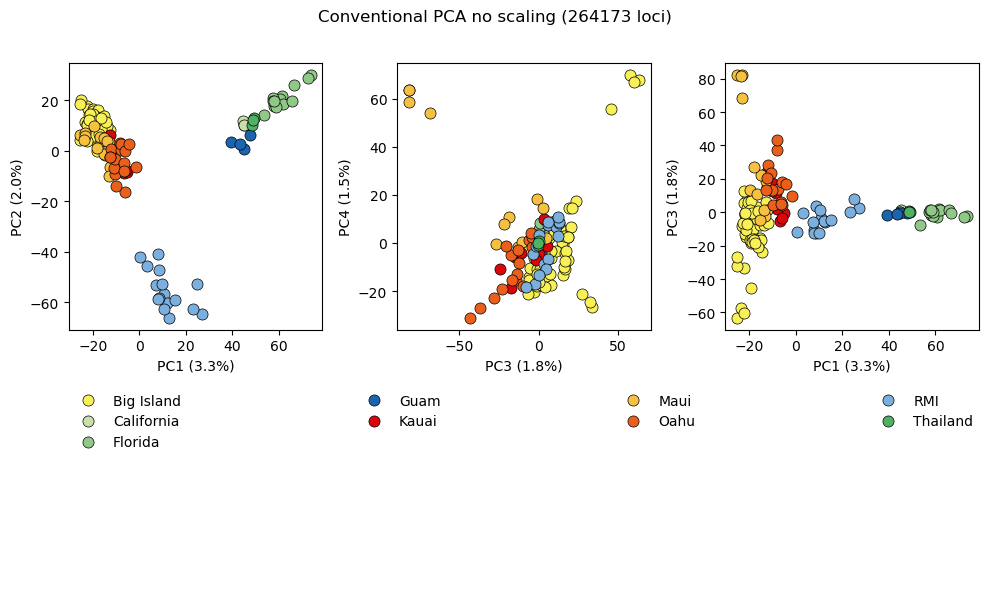

In [43]:
sample_labels = meta['ID'].values 

# font setting
plt.rcParams['font.family'] = 'Dejavu Sans'

def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population, pop_colors, sample_labels=None):
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in POPULATIONS:
        flt = (sample_population == pop)
        ax.plot(-x[np.where(flt)], y[np.where(flt)], marker=pop_colors[pop][1], linestyle=' ', color=pop_colors[pop][0],
                label="{:s}".format(pop),
                markersize=8, mec='k', mew=.5, clip_on=False)
        
        # labelling
        if sample_labels is not None:
            for i in np.where(flt)[0]:
                ax.text(-x[i], y[i], sample_labels[i], fontsize=6, ha='right', va='bottom', clip_on=True)

    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
def fig_pca2(coords, model, title, sample_population=None, pop_colors=None, sample_labels=None):
    if sample_population is None:
        sample_population = df_samples.population.values
    
    gs = gridspec.GridSpec(2,3, height_ratios=(1,.75))
    fig = plt.figure(figsize=(10, 6))
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    ax4 = plt.subplot(gs[0,2])

    plot_pca_coords(coords, model, 0, 1, ax1, sample_population, pop_colors, sample_labels)
    plot_pca_coords(coords, model, 2, 3, ax2, sample_population, pop_colors, sample_labels)
    plot_pca_coords(coords, model, 0, 2, ax4, sample_population, pop_colors, sample_labels)
    
    ax3.axis('off')
    handles, labels = ax1.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])
    labels, handles = zip(*sorted_handles_labels)

    ax3.legend(handles, labels, numpoints=1, fontsize=10, ncol=4, mode="expand", loc='upper center',
               frameon=False, borderaxespad=0.)
    
    fig.suptitle(title, y=.99)
    fig.tight_layout(rect=(0,0,1,.975))
    
    return fig

#if want to label on each dots, add label code here / sample_labels=sample_labels
fig = fig_pca2(coords2, model2, 'Conventional PCA no scaling ('+str(gn.shape[0])+' loci)', 
               sample_population=meta[GROUP_COL].values,
               pop_colors=POP_COLOURS
               )

plt.savefig('PCA_albo_Pacific_Feb042025.svg')
plt.savefig('PCA_albo_Pacific_Feb042025.png')

In [40]:
# PC explained variance ratio
# e.g. 1st number 0.09 in the array means 9% of variance explains PC1
model2.explained_variance_ratio_


array([0.0329345 , 0.02040586, 0.0180183 , 0.01460742, 0.01388843,
       0.01340192, 0.01259471, 0.01196592, 0.01146843, 0.01137373],
      dtype=float32)